# Importing Libraries

In [ ]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [ ]:
from zipfile import ZipFile
# file_name = '/content/drive/MyDrive/4-2/project-472/test.zip'
file_name2 = '/content/drive/MyDrive/Level4Term2/CSE472/project-472/Notebooks/state-farm-distracted-driver-detection.zip'
# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')
with ZipFile(file_name2, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# DATA_DIR = "../input/state-farm-distracted-driver-detection/imgs"
DATA_DIR = "./imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")

CSV_DIR = os.path.join(os.getcwd(),"csv_files")

MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [ ]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)
    

Model path does not exists
Model path created


In [ ]:
os.listdir(os.getcwd())

['.config',
 'imgs',
 'csv_files',
 'sample_submission.csv',
 'pickle',
 'driver_imgs_list.csv',
 'model',
 'drive',
 'sample_data']

In [ ]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))


In [ ]:
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

In [ ]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c9': 0, 'c0': 1, 'c1': 2, 'c5': 3, 'c8': 4, 'c7': 5, 'c6': 6, 'c2': 7, 'c3': 8, 'c4': 9}
(22424, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

**work on Driver ID**

In [ ]:
# SEED = 42
# import random
# import time
# # random
# random.seed(seed)
# # Numpy
# np.random.seed(seed)

In [ ]:
csv_file_path = os.path.join(os.getcwd(), 'driver_imgs_list.csv')

In [ ]:
df = pd.read_csv(csv_file_path) # csvファイルの読み込み
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
data_train.head(5)

,Filename,ClassName
0,./imgs/train/c5/img_40535.jpg,3
1,./imgs/train/c5/img_9728.jpg,3
2,./imgs/train/c5/img_47157.jpg,3
3,./imgs/train/c5/img_93626.jpg,3
4,./imgs/train/c5/img_45097.jpg,3


In [ ]:
# df['title'] = df['title'].str.replace(name, symbol)
data_train['img'] = 0

In [ ]:
data_train.head(5)

,Filename,ClassName,img
0,./imgs/train/c5/img_40535.jpg,3,0
1,./imgs/train/c5/img_9728.jpg,3,0
2,./imgs/train/c5/img_47157.jpg,3,0
3,./imgs/train/c5/img_93626.jpg,3,0
4,./imgs/train/c5/img_45097.jpg,3,0


In [ ]:
data_train['Filename'][0].split('/')[-1]

'img_40535.jpg'

In [ ]:
data_train['img'] = data_train['Filename'].apply(lambda x: x.split('/')[-1])

In [ ]:
data_train.head(5)

,Filename,ClassName,img
0,./imgs/train/c5/img_40535.jpg,3,img_40535.jpg
1,./imgs/train/c5/img_9728.jpg,3,img_9728.jpg
2,./imgs/train/c5/img_47157.jpg,3,img_47157.jpg
3,./imgs/train/c5/img_93626.jpg,3,img_93626.jpg
4,./imgs/train/c5/img_45097.jpg,3,img_45097.jpg


In [ ]:
merged_inner = pd.merge(left=df, right=data_train, left_on='img', right_on='img')


In [ ]:
merged_inner.head(5)

,subject,classname,img,Filename,ClassName
0,p002,c0,img_44733.jpg,./imgs/train/c0/img_44733.jpg,1
1,p002,c0,img_72999.jpg,./imgs/train/c0/img_72999.jpg,1
2,p002,c0,img_25094.jpg,./imgs/train/c0/img_25094.jpg,1
3,p002,c0,img_69092.jpg,./imgs/train/c0/img_69092.jpg,1
4,p002,c0,img_92629.jpg,./imgs/train/c0/img_92629.jpg,1


In [ ]:
merged_inner = merged_inner.drop('classname', axis=1)

In [ ]:
merged_inner.head(5)

,subject,img,Filename,ClassName
0,p002,img_44733.jpg,./imgs/train/c0/img_44733.jpg,1
1,p002,img_72999.jpg,./imgs/train/c0/img_72999.jpg,1
2,p002,img_25094.jpg,./imgs/train/c0/img_25094.jpg,1
3,p002,img_69092.jpg,./imgs/train/c0/img_69092.jpg,1
4,p002,img_92629.jpg,./imgs/train/c0/img_92629.jpg,1


In [ ]:
by_drivers = df.groupby('subject')
unique_drivers = by_drivers.groups.keys() 

print('unique drivers: ',len(unique_drivers)) 
print('total images: ',len(df)) 
print('mean of images: ', round(df.groupby('subject').count()['classname'].mean()))

category_num = len(df['classname'].unique())
print('category_num: ', category_num)

unique drivers:  26
total images:  22424
mean of images:  862
category_num:  10


In [ ]:
import plotly.express as px
px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

In [ ]:
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

In [ ]:
data_train = merged_inner.copy()

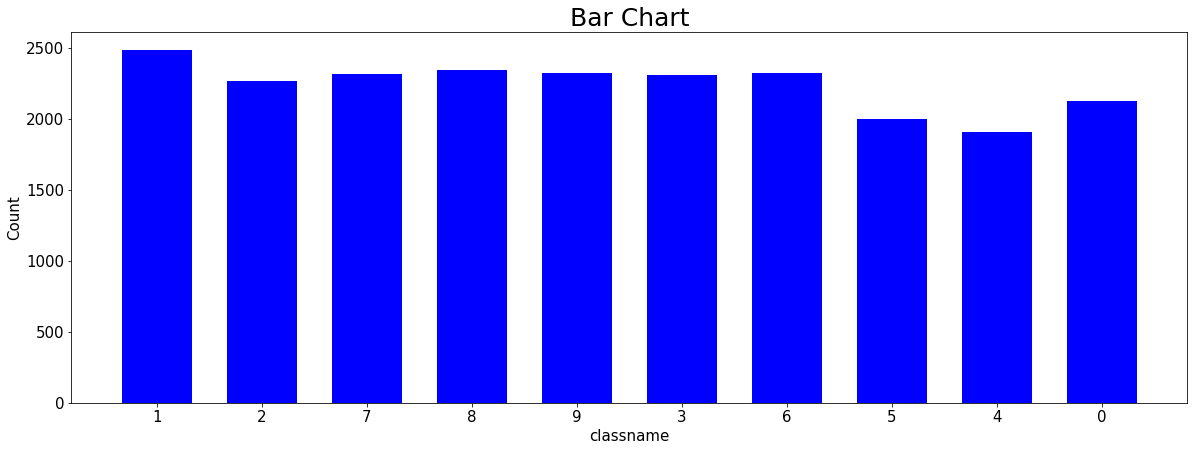

In [ ]:


nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [ ]:
data_test.head()

,FileName,ClassName
0,./imgs/test/img_94206.jpg,test
1,./imgs/test/img_99663.jpg,test
2,./imgs/test/img_56635.jpg,test
3,./imgs/test/img_65374.jpg,test
4,./imgs/test/img_80133.jpg,test


In [ ]:
labels_encoding = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
labels_encoding

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
data_test.shape

(79726, 2)

## Observation:
1. There are total 22424 training samples
2. There are total 79726 training samples
3. The training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data

## Converting into numerical values

In [ ]:
# labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_encoding = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

labels_id = {label_name:id for id,label_name in enumerate(labels_encoding)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [ ]:
# with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
#     pickle.dump(labels_id,handle)

In [ ]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


## Splitting into Train and Test sets

In [ ]:
data_train_new = data_train.copy()

In [ ]:
from sklearn.model_selection import train_test_split

subjects = data_train.subject.unique()

subjects_train, subjects_test = train_test_split(subjects, test_size=0.2)

train = data_train_new[data_train_new.subject.isin(subjects_train)]
val = data_train_new[data_train_new.subject.isin(subjects_test)]

# xtrain,xtest,ytrain,ytest = train_test_split(data_train_new.iloc[:,0],labels,test_size = 0.0001,random_state=42)

In [ ]:
train['subject'].unique()

array(['p002', 'p012', 'p014', 'p015', 'p022', 'p024', 'p026', 'p035',
       'p041', 'p047', 'p049', 'p050', 'p051', 'p056', 'p061', 'p064',
       'p066', 'p072', 'p075', 'p081'], dtype=object)

In [ ]:
val['subject'].unique()

array(['p016', 'p021', 'p039', 'p042', 'p045', 'p052'], dtype=object)

In [ ]:
output_col = 'ClassName'
y_train = train[output_col]
X_train = train.copy()
X_train.drop(output_col, axis='columns', inplace=True)

# X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# X_train = np.reshape(X_train, (len(X_train), len(X_train[0])))
# y_train = np.reshape(y_train, (len(y_train), 1))

y_val = val[output_col]
X_val = val.copy()
X_val.drop(output_col, axis='columns', inplace=True)

# X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

# X_val = np.reshape(X_val, (len(X_val), len(X_val[0])))
# y_val = np.reshape(y_val, (len(y_val), 1))

In [ ]:
y_val

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
xtrain = X_train.copy()
xvalid = X_val.copy() 
ytrain = y_train.copy() 
yvalid = y_val.copy() 

In [ ]:
xtrain = xtrain.drop('subject', axis=1)
xtrain = xtrain.drop('img', axis=1)

xvalid = xvalid.drop('subject', axis=1)
xvalid = xvalid.drop('img', axis=1)

In [ ]:
# xtrain = xtrain[:].values
# xvalid = xvalid[:].values

In [ ]:
xtrain.head()

In [ ]:
b = np.zeros((ytrain.size, ytrain.max()+1))
b[np.arange(ytrain.size),ytrain] = 1
ytrain = b

In [ ]:
len(ytrain)

17403

In [ ]:
b = np.zeros((yvalid.size, yvalid.max()+1))
b[np.arange(yvalid.size),yvalid] = 1
yvalid = b

In [ ]:
len(yvalid)

5021

### Converting into 64*64 images 
You can substitute 64,64 to 224,224 for better results only if ram is >32gb

In [ ]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain['Filename']).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xvalid['Filename']).astype('float32')/255 - 0.5



  0%|          | 0/17403 [00:00<?, ?it/s]

  0%|          | 9/17403 [00:00<03:13, 89.74it/s]

  0%|          | 21/17403 [00:00<02:54, 99.87it/s]

  0%|          | 31/17403 [00:00<03:06, 93.32it/s]

  0%|          | 41/17403 [00:00<03:37, 79.66it/s]

  0%|          | 51/17403 [00:00<03:22, 85.66it/s]

  0%|          | 62/17403 [00:00<03:09, 91.30it/s]

  0%|          | 72/17403 [00:00<03:11, 90.73it/s]

  0%|          | 82/17403 [00:00<03:08, 91.83it/s]

  1%|          | 92/17403 [00:01<03:07, 92.17it/s]

  1%|          | 102/17403 [00:01<03:15, 88.66it/s]

  1%|          | 111/17403 [00:01<03:15, 88.50it/s]

  1%|          | 120/17403 [00:01<03:49, 75.27it/s]

  1%|          | 128/17403 [00:01<04:08, 69.41it/s]

  1%|          | 136/17403 [00:01<05:00, 57.44it/s]

  1%|          | 143/17403 [00:01<04:55, 58.40it/s]

  1%|          | 150/17403 [00:02<05:20, 53.76it/s]

  1%|          | 156/17403 [00:02<06:13, 46.15it/s]

  1%|          | 162/17403 [00:02<05:53, 48.81it/s]

  1%|      

# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG16 model
2. Using the n-1 layers of VGG16 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [ ]:
model = VGG16 (include_top=False)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

157/157 [==============================] - 217s 1s/step


In [ ]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17403, 2, 2, 512)
Validation shape (5021, 2, 2, 512)


In [ ]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [ ]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

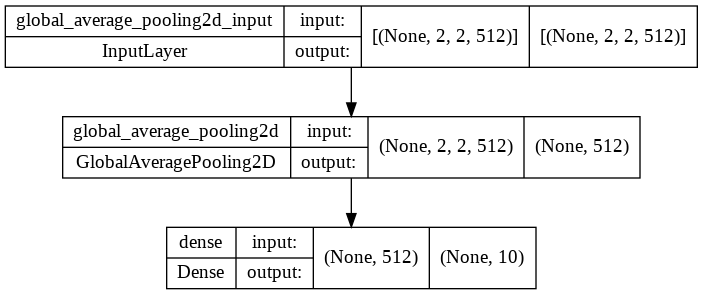

In [ ]:
plot_model(VGG16_model,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

In [ ]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = VGG16_model.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, yvalid),epochs=400, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/400
1073/1088 [============================>.] - ETA: 0s - loss: 1.2226 - accuracy: 0.6801
Epoch 1: val_accuracy improved from -inf to 0.47321, saving model to /content/model/vgg16/distracted-01-0.47.hdf5
1088/1088 [==============================] - 6s 5ms/step - loss: 1.2196 - accuracy: 0.6816 - val_loss: 1.5857 - val_accuracy: 0.4732
Epoch 2/400
1086/1088 [============================>.] - ETA: 0s - loss: 0.9775 - accuracy: 0.7493
Epoch 2: val_accuracy did not improve from 0.47321
1088/1088 [==============================] - 6s 6ms/step - loss: 0.9773 - accuracy: 0.7494 - val_loss: 1.5297 - val_accuracy: 0.4475
Epoch 3/400
1083/1088 [============================>.] - ETA: 0s - loss: 0.8331 - accuracy: 0.7879
Epoch 3: val_accuracy did not improve from 0.47321
1088/1088 [==============================] - 5s 5ms/step - loss: 0.8325 - accuracy: 0.7881 - val_loss: 1.5547 - val_accuracy: 0.4392
Epoch 4/400
1088/1088 [==============================] - ETA: 0s - loss: 0.7343 - accura

 37%|███▋      | 6355/17403 [47:58<1:23:24,  2.21it/s]


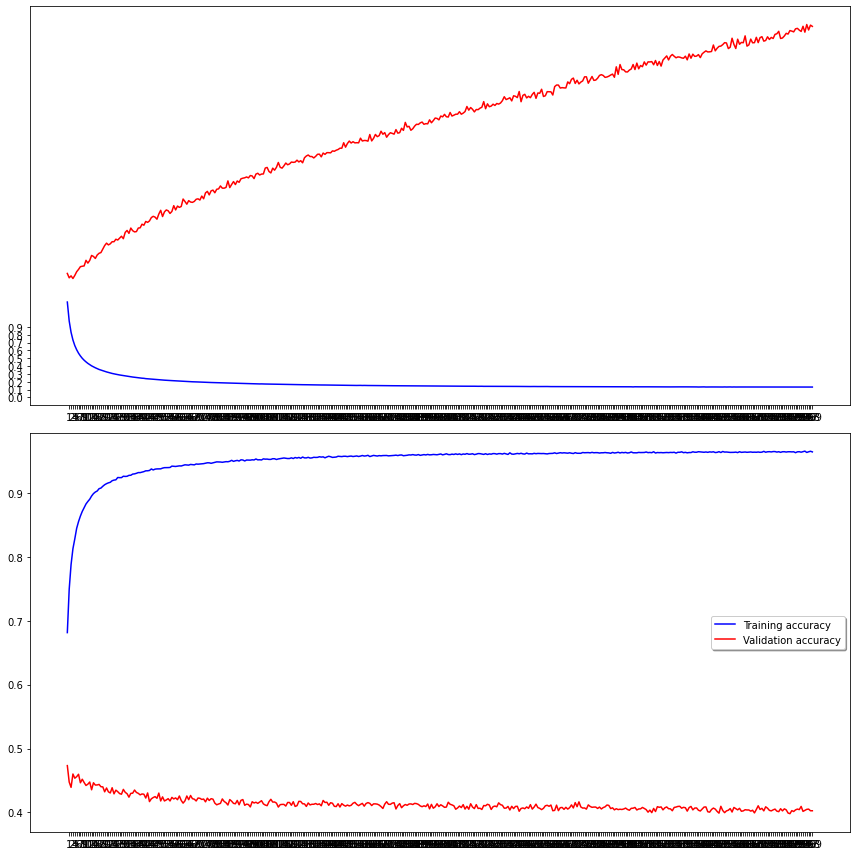

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG16_model.predict(train_vgg16,verbose=1)

544/544 [==============================] - 2s 3ms/step


## Confusion Matrix

In [ ]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [ ]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytrain,axis=1)

In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

from sklearn.metrics import log_loss
loss = log_loss(ytest,ypred)
print('loss score: %f' % loss)

Accuracy: 0.964661
Precision: 0.964813
Recall: 0.964661
F1 score: 0.964665
loss score: 0.131356


In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model_path = '/content/drive/MyDrive/Level4Term2/CSE472/project-472/Notebooks/saved_model/my_model_VGG_92_uniq_sub_id'
VGG16_model.save(model_path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Level4Term2/CSE472/project-472/Notebooks/saved_model/my_model_VGG_92_uniq_sub_id/assets
